In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 
from numba import njit

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [2]:
##### function creating opinion distribution #####
def opinion_dist(N, dist_type, dist_params):
    
    if dist_type == 'normal':
        exp_value = dist_params[0]
        std_deviation = dist_params[1]
        opinion = np.random.normal(exp_value, std_deviation, N) 
        return opinion
    elif dist_type == 'uniform':
        lower_border = dist_params[0]
        upper_border = dist_params[1]
        opinion = np.random.uniform(lower_border, upper_border, N) 
        return opinion
    elif dist_type == 'beta':
        alpha = dist_params[0]
        beta = dist_params[1]
        opinion = (np.random.beta(alpha, beta, N)-0.5)*2 
        return opinion
    else:
        print('unknown dist_type "%s"' %dist_type)
        return

##### opinion rule weight function #####
@njit
def f(opinion_a, opinion_b, mu, epsilon, scale, interaction_width):

    weight = mu*(1 - (1/epsilon)*abs(opinion_a - opinion_b))
    
    if abs(opinion_a - opinion_b) > interaction_width:
        return 0
    elif weight < 0:
        return weight/scale
    else:
        return weight   
    
@njit    
##### opinion truncating function #####
def trunc_opinion(opinion, border, alpha, beta):
    reset = 0
    if opinion > border:
        new_opinion = np.random.beta(alpha, beta)
        reset = 1
    elif opinion < -border:
        new_opinion = -np.random.beta(alpha, beta)
        reset = 1
    else:
        new_opinion = opinion
    
    return new_opinion, reset

@njit
##### opinion dynamics ##### 
def opinion_dynamics(opinion_dist_a, opinion_dist_b, simulation_time, parameter):
    
    opinion_timeline = np.zeros((50, simulation_time))
    N_reset = 0
    
    for i in range(simulation_time):
        x = np.random.randint(0, len(opinion_dist_a))
        y = np.random.randint(0, len(opinion_dist_b))

        opinion_a = opinion_dist_a[x]  
        opinion_b = opinion_dist_b[y]
        
        weight = f(opinion_a, opinion_b, parameter[0], parameter[1], parameter[2], parameter[3])
        
        if weight < 0:
            random = np.random.rand()
            
            if random < parameter[4]:
                opinion_dist_a = np.delete(opinion_dist_a, x)
                new_opinion = np.random.normal(0, 0.22, int(parameter[5]))
                opinion_dist_a = np.concatenate((opinion_dist_a, new_opinion), axis=0)
                reset = 0
            
            else:
                opinion_dist_a[x] += weight*(opinion_b - opinion_a)
                opinion_dist_a[x], reset = trunc_opinion(opinion_dist_a[x], parameter[6], parameter[7], parameter[8])
                
        else:    
            opinion_dist_a[x] += weight*(opinion_b - opinion_a)
            opinion_dist_a[x], reset = trunc_opinion(opinion_dist_a[x], parameter[6], parameter[7], parameter[8])
        
        #for k in range(50):
        #    opinion_timeline[k, i] = opinion_dist_a[k] ##### activate when wanting to plot!
        
        N_reset += reset
        
    return opinion_dist_a, opinion_timeline, N_reset    

@njit
##### initializing opinion dynamics parameter #####
def set_parameter(mu, epsilon, reject_scale, interaction_width, leave_prob, join_rate, border, reset_alpha, reset_beta):
    parameter = np.zeros(9, dtype='float')
    parameter[0] = mu
    parameter[1] = epsilon
    parameter[2] = reject_scale
    parameter[3] = interaction_width
    parameter[4] = leave_prob
    parameter[5] = join_rate
    parameter[6] = border
    parameter[7] = reset_alpha
    parameter[8] = reset_beta
    
    return parameter

##### plotting functions #####
def plot_initial_state(user_opinion, post_opinion, border):
    x_max = border+0.1
    x_min = -border-0.1
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True) 
    axs[0].set_title('Initial User Opinion Dist. (%s, %0.1f, %0.1f)' %(user_dist_type, user_dist_type_params[0],  user_dist_type_params[1]))
    axs[0].hist(user_opinion, density=True, bins=30)
    axs[0].set_xlim([x_min,x_max])
    axs[0].set_xlabel('opinion')
    
    axs[1].set_title('Initial Post Opinion Dist. (%s, %0.1f, %0.1f)' %(post_dist_type, post_dist_type_params[0],  post_dist_type_params[1]))
    axs[1].hist(post_opinion, density=True, bins=30)
    axs[1].set_xlim([x_min,x_max])
    axs[1].set_xlabel('opinion')
    plt.tight_layout()   
    return

def plot_final_state(user_opinion, total_runtime, border):
    x_max = border+0.1
    x_min = -border-0.1
    
    plt.figure()
    #plt.title('Final User Opinion Dist. (t=%0.e iterations)' %(total_runtime))
    plt.hist(user_opinion, density=True, bins=100)
    plt.xlim([x_min,x_max])
    plt.xlabel('opinion')
    plt.show()
    print("Amount of users:", len(user_opinion))
    return

def plot_timeline(start, end, timelines, border):
    x_max = border+0.1
    x_min = -border-0.1
    
    plt.figure()
    t = np.arange(int(start), int(end))
    for i in range(50):
        plt.plot(timelines[i, t], t, linewidth = 0.7)
    plt.xlim([x_min,x_max])
    plt.xlabel("opinion")
    plt.ylabel("runtime")
    plt.show()
    return

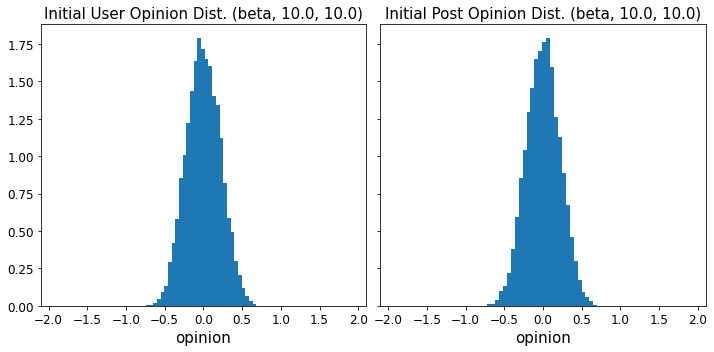

In [3]:
##### user distribution parameter #####
user_N = 10**4
user_dist_type = 'beta'
user_dist_type_params = [10, 10]

##### post distribution parameter #####
post_N = 10**4
post_dist_type = 'beta'
post_dist_type_params = [10, 10]

##### opinion dynamics parameter #####
parameter = set_parameter(mu=0.1, epsilon=0.35, reject_scale=1, interaction_width=0.7, leave_prob=0, join_rate=0, border=2, reset_alpha=5, reset_beta=5)

##### create and plot initial distributions #####
user_opinion = opinion_dist(user_N, user_dist_type, user_dist_type_params)
post_opinion = opinion_dist(post_N, post_dist_type, post_dist_type_params)

plot_initial_state(user_opinion, post_opinion, parameter[6])
total_runtime = 0

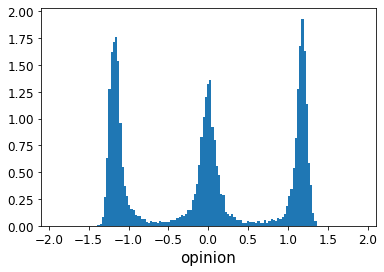

Amount of users: 10000
Users that reached the border: 0 
Total runtime: 2e+06


In [4]:
##### run simulation #####
simulation_time = 2*10**6
user_opinion, timelines, N_reset = opinion_dynamics(user_opinion, post_opinion, simulation_time, parameter)
total_runtime += simulation_time

plot_final_state(user_opinion, total_runtime, parameter[6])
print('Users that reached the border: %g \nTotal runtime: %g'%(N_reset, total_runtime))

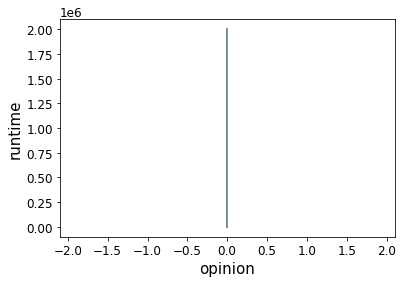

In [5]:
##### plotting the development of 50 users (needs to be activated in opinion dynamics function) #####
plot_timeline(0, simulation_time, timelines, parameter[6])

In [6]:
##### loop for further parameter analysis #####

##### user distribution parameter #####
user_N = 10**4
user_dist_type = 'beta'
user_dist_type_params = [10, 10]

##### post distribution parameter #####
post_N = 10**4
post_dist_type = 'beta'
post_dist_type_params = [0.5, 0.5]

step_mu = np.arange(0.1, 0.6, 0.1)
step_eps = np.arange(0.3, 0.6, 0.05)

rows = len(step_mu)
columns = len(step_eps)

simulation_time = 2*10**6

data = np.zeros((rows, columns, user_N))

for i in range(rows):
    for j in range(columns):
        user_opinion = opinion_dist(user_N, user_dist_type, user_dist_type_params)
        post_opinion = opinion_dist(post_N, post_dist_type, post_dist_type_params)
        parameter = set_parameter(mu=step_mu[i], epsilon=step_eps[j], reject_scale=1, interaction_width=0.7, leave_prob=0, join_rate=0, border=2, reset_alpha=5, reset_beta=5)
        data[i,j], timelines, N_reset = opinion_dynamics(user_opinion, post_opinion, simulation_time, parameter)
        
#np.save('varying_mu(%0.2f-%0.2f)_eps(%0.2f-%0.2f)_%0.1f_%0.1f_%0.1f_%0.1f'%(np.amin(step_mu), np.amax(step_mu), np.amin(step_eps), np.amax(step_eps), user_dist_type_params[0],user_dist_type_params[1],post_dist_type_params[0],post_dist_type_params[1]), data)        

In [7]:
#data = np.load('')

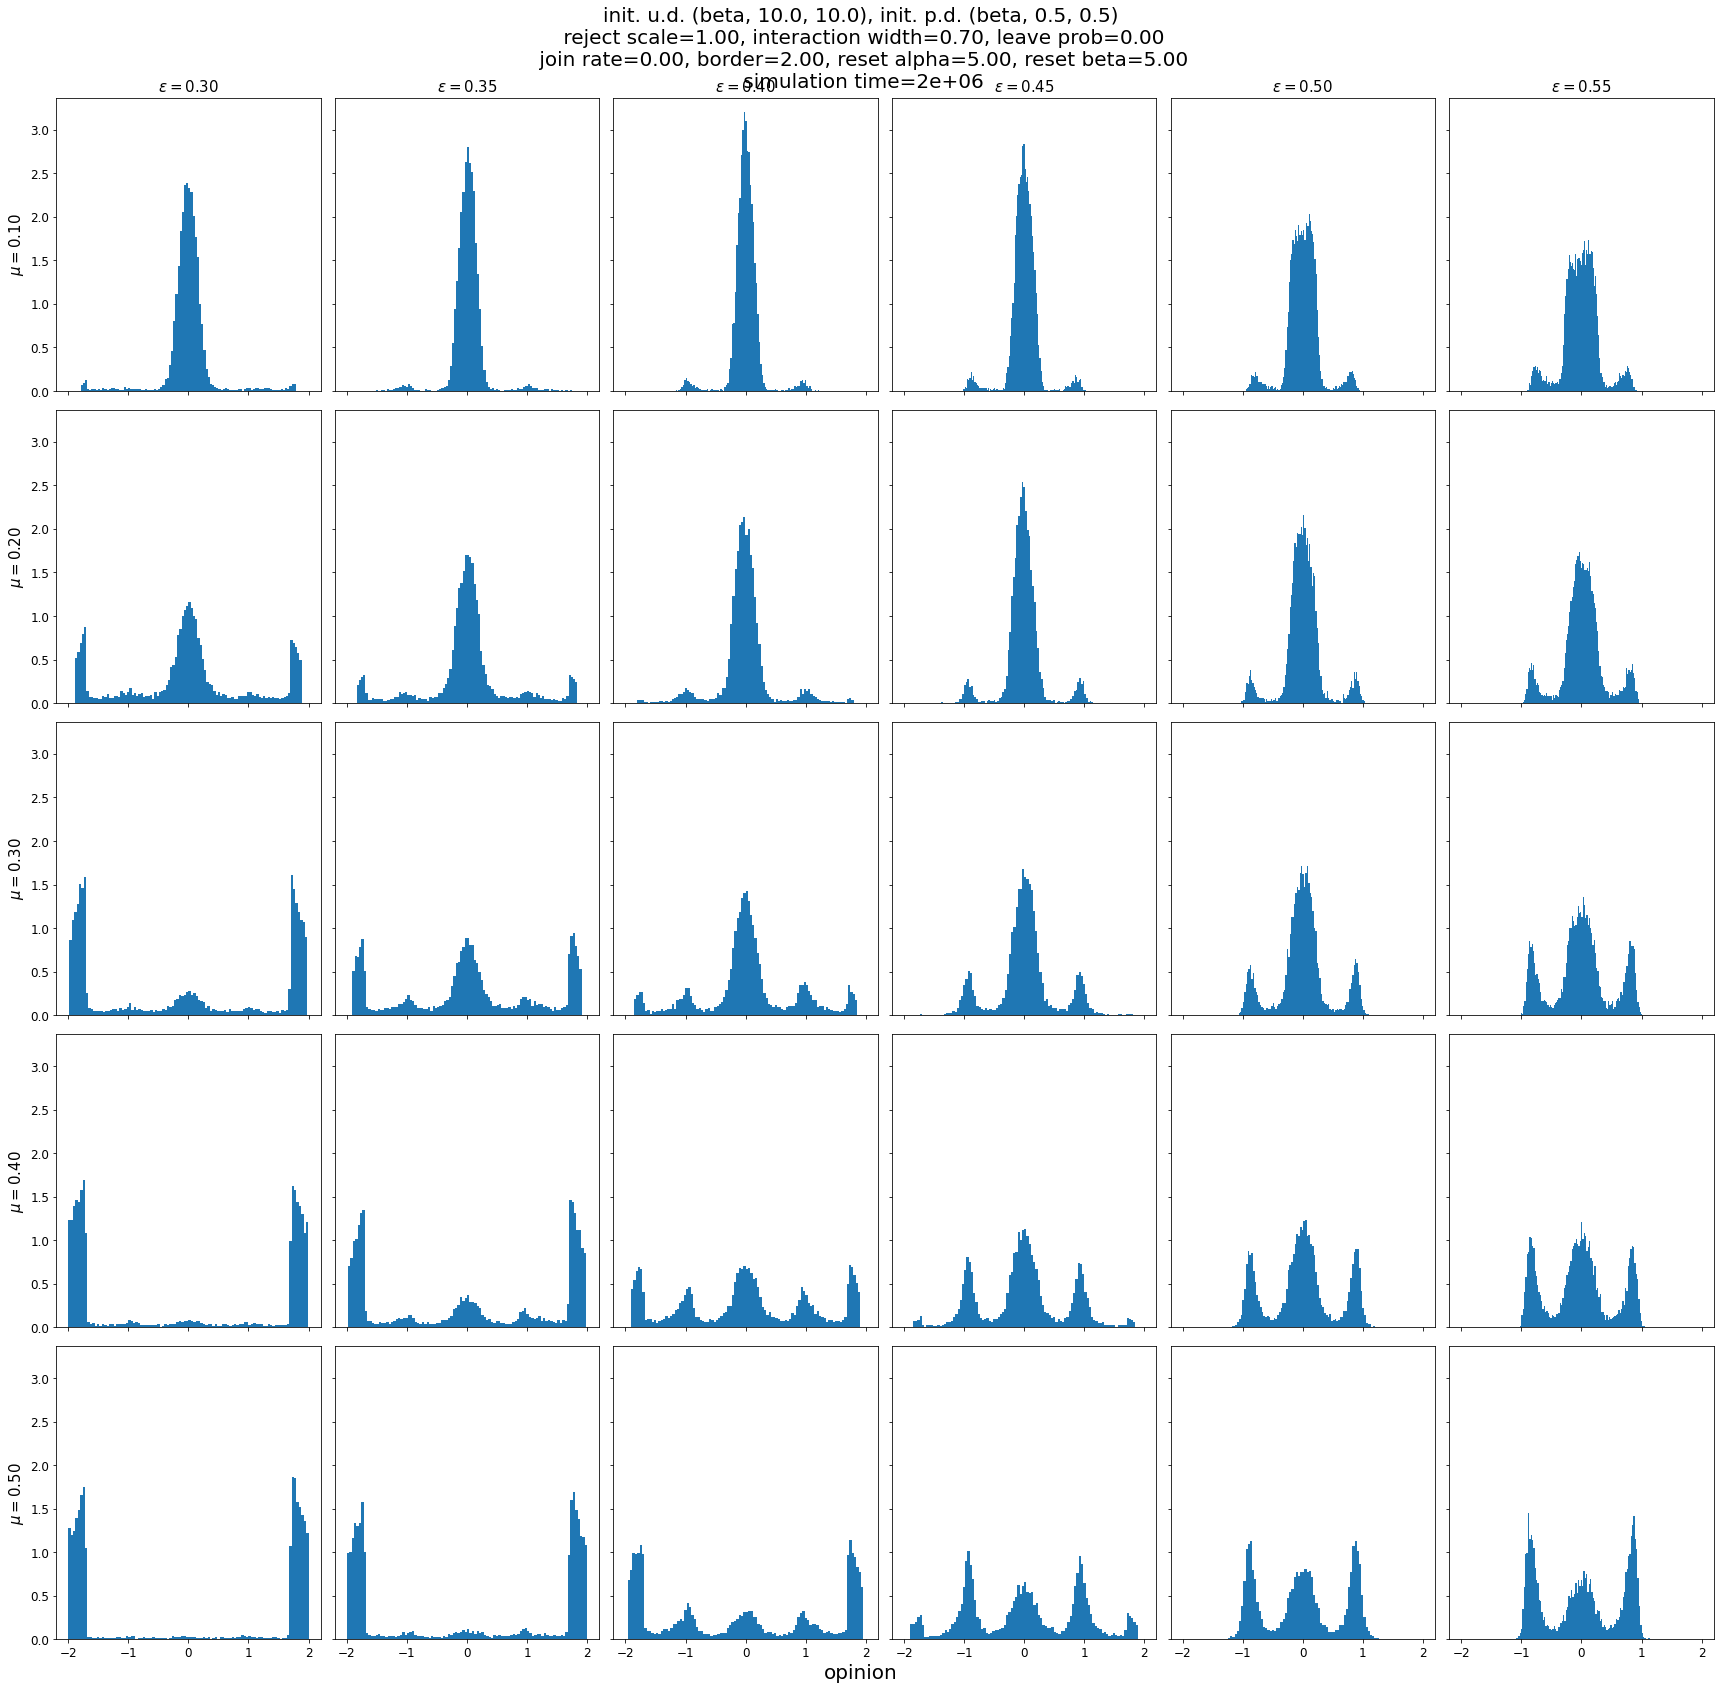

In [8]:
fig, axs = plt.subplots(rows, columns, sharey=True, sharex=True,figsize=(24,24))   

for i in range(rows):
    for j in range(columns):
        axs[i,j].hist(data[i,j], density=True, bins=100)

fig.suptitle('init. u.d. (%s, %0.1f, %0.1f), init. p.d. (%s, %0.1f, %0.1f)\n reject scale=%0.2f, interaction width=%0.2f, leave prob=%0.2f\n join rate=%0.2f, border=%0.2f, reset alpha=%0.2f, reset beta=%0.2f\n simulation time=%0.1g'
             %(user_dist_type,user_dist_type_params[0],user_dist_type_params[1],post_dist_type,post_dist_type_params[0],post_dist_type_params[1],
               parameter[2],parameter[3],parameter[4],parameter[5],parameter[6],parameter[7],parameter[8], simulation_time))

for i in range(rows):
    axs[i,0].set_ylabel(r'$\mu=%0.2f$'%(step_mu[i]))

for j in range(columns):
    axs[0,j].set_title(r'$\varepsilon=%0.2f$'%(step_eps[j]))

fig.supxlabel('opinion')
#plt.savefig('varying_mu(%0.2f-%0.2f)_eps(%0.2f-%0.2f)_%0.1f_%0.1f_%0.1f_%0.1f.pdf'%(np.amin(step_mu), np.amax(step_mu), np.amin(step_eps), np.amax(step_eps), user_dist_type_params[0],user_dist_type_params[1],post_dist_type_params[0],post_dist_type_params[1]), bbox_inches='tight')
plt.tight_layout()